# **Project: Amazon Product Recommendation System**

Building a collaborative filtering–based recommendation engine using Amazon product review data.

--------------
## **Context:**
--------------

With the rapid growth of digital data, consumers are faced with an overwhelming number of choices online. Recommendation systems help mitigate this problem by suggesting products that are most relevant to each user, thereby improving engagement and sales.

E-commerce platforms such as Amazon, Walmart, and Target rely heavily on these systems, which use techniques like collaborative filtering and content-based filtering to provide personalized recommendations. This project focuses on replicating a simplified version of Amazon’s recommendation logic, demonstrating how machine learning can be used to personalize shopping experiences at scale.

----------------
## **Objective:**
----------------

The goal of this project is to build a recommendation system that predicts products a user is likely to rate highly, based on their past ratings. Using the Amazon product reviews dataset, this model leverages collaborative filtering techniques to recommend items similar to those a user has previously interacted with.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem



Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [ ]:
!pip install numpy==1.26.4 --quiet

## **Importing the necessary libraries and overview of the dataset**

In [ ]:
!pip install scikit-surprise --quiet

# STEP 5: Now import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import SVD
from collections import defaultdict
from surprise.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')


### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
electronics = pd.read_csv("/content/drive/MyDrive/REC SYSTEMS/ratings_Electronics.csv")

In [ ]:
electronics.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [ ]:
electronics.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

In [ ]:
electronics.drop('timestamp', axis = 1, inplace = True)

In [ ]:
electronics.head()

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [ ]:
df = electronics.copy()

In [ ]:
df.head()

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

**Write your observations here: We have 65,290 reviews**

### **Data types**

In [ ]:
# Check Data types and provide observations
df_final.dtypes

,0
user_id,object
prod_id,object
rating,float64


### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.isnull().sum()

,0
user_id,0
prod_id,0
rating,0


 Luckily we have no misisng values**

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


In [ ]:
df_final['user_id'] = df_final['user_id'].astype('str')

We convert the user ID column to a string since it contians letters and numbers just in case it is useful later

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe()

,rating
count,65290.000000
mean,4.294808
std,0.988915
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**The mean and the 25th percentile seems to be around 4 while the max and 50th and 75th percentile is at 5 which indiciates the ratings are heavily skewed towards higher ratings**

### **Checking the rating distribution**

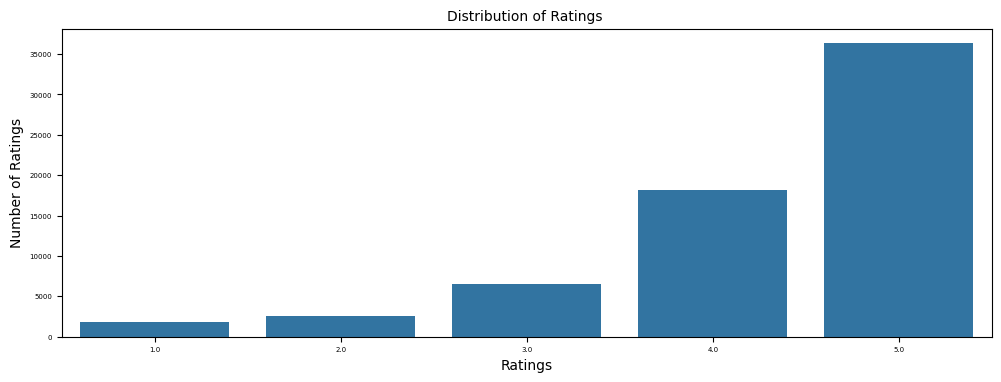

In [ ]:
# Create the bar plot and provide observations
# Distribution of ratings
plt.figure(figsize = (12, 4))
sns.countplot(x="rating", data=df_final)

plt.tick_params(labelsize = 5)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

**This confirms what we hyptohesized above with the statistical summary**

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
df_final['user_id'].nunique()

1540

In [ ]:
df_final['prod_id'].nunique()

5689

**This is very interesting, out of 65290 reviews only 1540 of them are from unique users and only 5689 of the porducts are unique. This also means that hypothetically there could be 1540 x 65290 = 8,761,060 reviews but we know we only have 65290 so that means not every user has rated every book so we can build a recommendation system to recommend books to users which they have not interacted with.**

In [ ]:
df_final.groupby(['user_id', 'prod_id']).count()

rating
user_id        prod_id           
A100UD67AHFODS B00004Z5M1       1
               B0001D3K8A       1
               B000233WJ6       1
               B0002KVQBA       1
               B0002SQ2P2       1
...                           ...
AZOK5STV85FBJ  B005PQTYHE       1
               B006MPRFJQ       1
               B00AANMVNQ       1
               B00B25P27S       1
               B00FB2XNCE       1

[65290 rows x 1 columns]

In [ ]:
df_final.groupby(['user_id', 'prod_id']).count()['rating'].sum()

65290

The sum is equal to the total number of observations which implies there is only one interaction between a book and a user

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
(df_final['user_id'].value_counts())[0:10]

,count
user_id,
ADLVFFE4VBT8,295
A3OXHLG6DIBRW8,230
A1ODOGXEYECQQ8,217
A36K2N527TXXJN,212
A25C2M3QF9G7OQ,203
A680RUE1FDO8B,196
A1UQBFCERIP7VJ,193
A22CW0ZHY3NJH8,193
AWPODHOB4GFWL,184


**Write your observations here: User ADLVFFE4VBT8 has given the most reviews with 295.**

Let's now see which product has the highest number of reviews/ratings in the dataset:

In [ ]:
(df_final['prod_id'].value_counts())[0:10]

,count
prod_id,
B0088CJT4U,206
B003ES5ZUU,184
B000N99BBC,167
B007WTAJTO,164
B00829TIEK,149
B00829THK0,137
B008DWCRQW,137
B002R5AM7C,128
B004CLYEDC,118


The product with ID B0088CJT4U has been interacted by the most users 206. But there is stilla. possibility of 1540-206 = 1334 more itneractions as we have 1540 unique users in our dataset. For those 1334 remaining we can build a recomenndation system to predict who is more likely to interact with this product. Also out of these 206 interactions we need to consider the dsitribution of ratings as well to check whether the product is the most liked or most disliked product.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product

count_rating = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings

final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})


# Sort the dataframe by average of ratings in the descending order

final_rating = final_rating.sort_values(by='avg_rating', ascending=False)


# See the first five records of the "final_rating" dataset


In [ ]:
final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
final_rating['rating_count'].value_counts()

,count
rating_count,
5,1082
6,796
7,637
8,495
9,416
...,...
55,1
97,1
164,1


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions

# Finding products with minimum number of interactions

# Sorting values with respect to average rating

def top_n_products(data, n, min_interaction=100):

    # Finding books with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

    # Sorting values w.r.t. average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.index[:n]



### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
res = list(top_n_products(final_rating, 5, 50))
# Name of the products
list_of_products = []
for i in res:
    list_of_products.append(df_final[df_final['prod_id']== str(i) ]['prod_id'].unique()[0])
list_of_products

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
res2 = list(top_n_products(final_rating, 5, 100))
# Name of the products
list_of_prod = []
for i in res2:
    list_of_prod.append(df_final[df_final['prod_id']== str(i) ]['prod_id'].unique()[0])
list_of_prod

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
df_rating = df_final.copy()

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 10))

# Loading the rating dataset
df_final = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(df_final, test_size=0.3, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}


# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1

algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)


# Fit the model on the training data

algo_knn_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(algo_knn_user)

RMSE: 1.0250
Precision:  0.86
Recall:  0.783
F_1 score:  0.82


**We observe that the baseline model has RMSE = 1.02 on the test set. We are getting a recall of 0.783 which means out of all relevant products, 78% are recommended. We are getting a precision of 0.86 which means out of all recommended products, 86% are relevant. The F_1 score is 0.82 which indiciates mostly recommended products are relavant and relevant products were recommended.**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
algo_knn_user.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**The predicted rating is 4.29**

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
unique_users = df_rating[df_rating['prod_id'] != 1400501466]['user_id'].unique()
print(unique_users)

['A3LDPF5FMB782Z' 'A1A5KUIIIHFF4U' 'A2XIOXRRYX0KZY' ... 'A215WH6RUDUCMP'
 'A38C12950IM24P' 'A2J4XMWKR8PPD0']


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
algo_knn_user.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**The predicted rating is 4.29**



### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(df_final)

# Best RMSE score

print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9725250410972444
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering

sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=6, verbose=False)

# Training the algorithm on the trainset

similarity_algo_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10

precision_recall_at_k(similarity_algo_optimized)


RMSE: 0.9630
Precision:  0.85
Recall:  0.809
F_1 score:  0.829


**After tuning hyperparameters RMSE for the test set has reduced from 1.02 to 0.9630. The F_1 score increased from 0.82 to 0.829. The model's performance has improved after hyperparamter tuning.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
similarity_algo_optimized.predict("A3LDPF5FMB782Z", 1400501466, r_ui = 5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_algo_optimized.predict("A34BZM6S9L7QI4", 1400501466, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**There is no difference in predictions between the baseline model and the tuned model**

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user

sim_options2 = {
    'name': 'msd',         # Use MSD similarity
    'user_based': True     # User-based collaborative filtering
}

algo_knn_user = KNNBasic(sim_options=sim_options2)

# Fit on full trainset
algo_knn_user.fit(trainset)


Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
nearest_neighbors = algo_knn_user.get_neighbors(0, k=5)

In [ ]:
print("The 5 most similar users to user 0 are:", nearest_neighbors)

The 5 most similar users to user 0 are: [16, 42, 44, 54, 58]


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

In [ ]:
df_rating=df_rating.drop_duplicates()

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_rating, "A3LDPF5FMB782Z", 5, similarity_algo_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B002WE6D44,5.000000
1,B00834SJSK,5.000000
2,B00006RVPW,5.000000
3,B002V8C3W2,4.888435
4,B007WTAJTO,4.882311


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
algo_knn_item = KNNBasic(sim_options=sim_options, random_state=1)

# Train the algorithm on the trainset, and predict ratings for the test set

algo_knn_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(algo_knn_item)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0232
Precision:  0.835
Recall:  0.758
F_1 score:  0.795


**We observe that the baseline model has RMSE=1.0232 and F_1 score = 0.795 on the test set.**

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
algo_knn_item.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Predicted rating is 4.29 similar to the previous model**




Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
algo_knn_item.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Predcited rating is 4.29**

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters

param_grid = {'k': [10,20,30], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# Fitting the data

grid_obj.fit(df_final)

# Find the best RMSE score

print(grid_obj.best_score['rmse'])
# Find the combination of parameters that gave the best RMSE score

print(grid_obj.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering

similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=30, min_k=6,verbose=False)

# Creating an instance of KNNBasic with optimal hyperparameter values

similarity_algo_optimized_item.fit(trainset)

# Training the algorithm on the trainset

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(similarity_algo_optimized_item)

RMSE: 0.9694
Precision:  0.836
Recall:  0.797
F_1 score:  0.816


**We can se that the RMSE has decreased from 1.0232 to 0.9694 and the F_1 score is better. So the model performance has improved.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
similarity_algo_optimized_item.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_algo_optimized_item.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Predicted rating is 4.29**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
similarity_algo_optimized_item.get_neighbors(0, k=5)

[53, 67, 106, 151, 156]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**


In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_rating, 'A1A5KUIIIHFF4U', 5, similarity_algo_optimized_item)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.291403
1,1400599997,4.291403
2,9983891212,4.291403
3,B00000DM9W,4.291403
4,B00000J1V5,4.291403


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1

svd = SVD(random_state=1)

# Training the algorithm on the trainset

svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8995
Precision:  0.86
Recall:  0.797
F_1 score:  0.827


**The result for SVD is better than both baseline and optimized item-item similarity based recommendation systems**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.270673152607236, details={'was_impossible': False})

**The predicted rating has finally changed and is 4.27**

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.54   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.538853147066661, details={'was_impossible': False})

**Predicted rating is 4.54**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune

param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation

gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data

gs_.fit(df_final)

# Best RMSE score

print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8981444701035063
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1

svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.4, random_state=1)

# Train the algorithm on the trainset

svd_optimized=svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8909
Precision:  0.862
Recall:  0.801
F_1 score:  0.83


**the model performance has not improved by much**




### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.267708222694929, details={'was_impossible': False})

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict('A34BZM6S9L7QI4', 1400501466, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.47   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid=1400501466, r_ui=None, est=4.473881163439849, details={'was_impossible': False})

### **Conclusion and Recommendations**

**In this case study we built recommendation systems using four different algorithms: Rank-based using averages, user-user similarity based collaboriatve filtering, item-item similarity based collaborative fitlering, model based (matrix factorization) collaborative filtering**
